In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import mean_squared_error as MSE

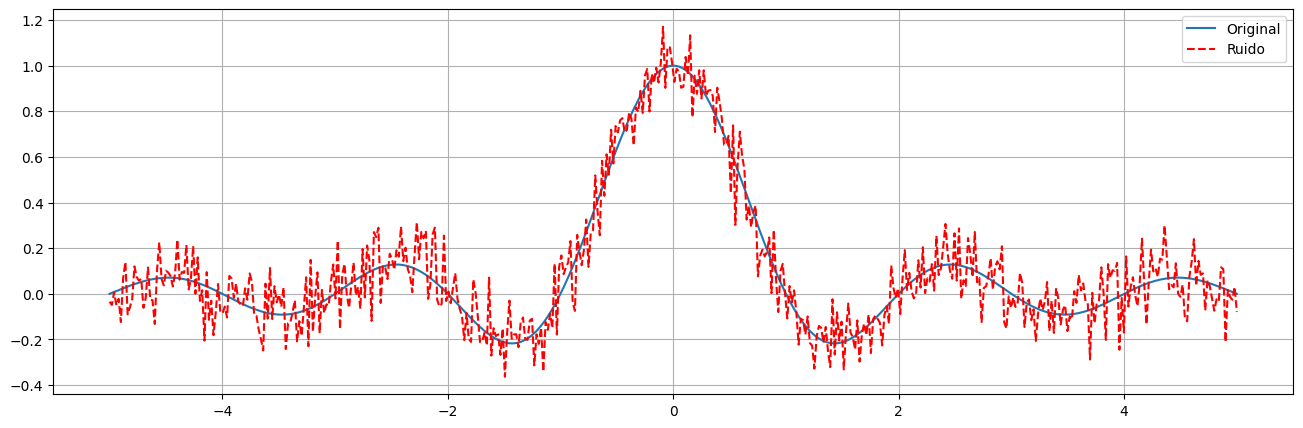

In [53]:
import numpy as np
import matplotlib.pyplot as plt

def sinc_generator(A=1.0, noise_std=0.1, N=500, t_max=5):
    # Crear vector de tiempo
    t = np.linspace(-t_max, t_max, N)

    # Generar señal sinc (np.sinc usa sinc(x) = sin(pi*x)/(pi*x))
    y_clean = A * np.sinc(t)

    # Agregar ruido gaussiano
    ruido = np.random.normal(0, noise_std, size=N)
    y = y_clean + ruido

    return t, y_clean, y

# Ejemplo de uso:
t, y_original, y_ruido = sinc_generator()
plt.figure(figsize=(16,5))
plt.plot(t, y_original, label='Original')
plt.plot(t, y_ruido, 'r--', label='Ruido')
plt.legend()
plt.grid()
plt.show()

In [80]:
#Reshaping
y_reshape = y_ruido.reshape(-1,1)
t_reshape = t.reshape(-1,1)

Q = np.arange(1,50)

#particionar datos
rs = ShuffleSplit(n_splits=1, random_state=0, test_size=0.3)
for i, (train_i, test_i) in enumerate(rs.split(y_reshape)):
   print(i)

#regresor
lambdaR = 1e-30#hiperparámetro de regularización
reg_mc = Ridge(alpha=lambdaR)
train_i = np.sort(train_i)
test_i = np.sort(test_i)

señales = [None] * len(Q) # Initialize the list with None values
error_noise = [None] * len(Q)
for q in Q:
  phiQ = PolynomialFeatures(degree=q, include_bias=False)
  Phi = phiQ.fit_transform(y_reshape)

  reg_mc.fit(Phi[train_i],t[train_i])
  t_mc = reg_mc.predict(Phi[test_i])
  señales[q-1] = t_mc
  error_noise[q-1] = MSE(t[test_i], t_mc)

0


Grado polinomio óptimo: 9
Error: 8.548102342330154


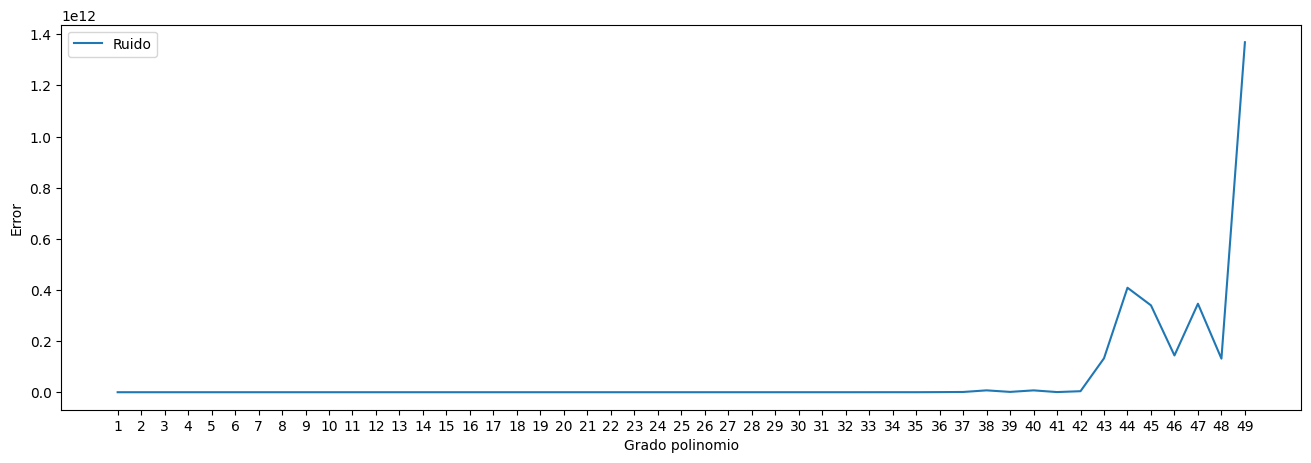

In [81]:
print(f"Grado polinomio óptimo: {np.argmin(error_noise)+1}")
print(f"Error: {error_noise[np.argmin(error_noise)]}")
plt.figure(figsize=(16,5))
plt.plot(Q, error_noise, label='Ruido')
plt.legend()
plt.xticks(Q)
plt.xlabel('Grado polinomio')
plt.ylabel('Error')
plt.show()

In [82]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def animar_aproximaciones(t, y_original, y_predichas, grados, test_indices):
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.set_title("Aproximación polinómica a la señal sinc")
    ax.set_xlabel("Tiempo")
    ax.set_ylabel("Amplitud")
    ax.grid()

    # Señal original en negro
    ax.plot(t, y_original, 'k', label="Original")

    # Línea de la predicción que se actualizará
    linea_pred, = ax.plot([], [], 'r', label="Predicción")
    texto_grado = ax.text(0.02, 0.95, '', transform=ax.transAxes, fontsize=12, va='top')
    ax.legend()

    def init():
        linea_pred.set_data([], [])
        texto_grado.set_text('')
        return linea_pred, texto_grado

    def update(frame):
        # Use the test_indices to plot the predicted signal at the correct time points
        linea_pred.set_data(t[test_indices], y_predichas[frame])
        texto_grado.set_text(f"Grado del polinomio: {grados[frame]}")
        return linea_pred, texto_grado

    ani = FuncAnimation(fig, update, frames=len(y_predichas), init_func=init, blit=True, interval=500, repeat=True)

    plt.close(fig)  # 👈 Importante para que no muestre una figura estática
    return HTML(ani.to_jshtml())  # 👈 Renderiza la animación como HTML

# Mostrar animación en Colab
animar_aproximaciones(t.flatten(), y_ruido.flatten(), señales, Q, test_i)

#HOUSING

In [75]:
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

# 1. Cargar dataset
housing = fetch_california_housing(as_frame=True)
X = housing.data[['MedInc']].values  # Usamos solo "MedInc" (ingreso medio) para graficar
y = housing.target.values

# 2. Particionar datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# 3. Configuración
grados = np.arange(1, 11)  # probaremos polinomios de grado 1 a 10
alpha = 1.0                # regularización

# Preparamos predicciones en un grid para graficar curvas suaves
X_plot = np.linspace(X.min(), X.max(), 300).reshape(-1, 1)

# Guardaremos las curvas predichas
curvas_pred = []

for q in grados:
    # Pipeline: escalado -> features polinómicas -> Ridge
    modelo = make_pipeline(
        StandardScaler(),
        PolynomialFeatures(degree=q, include_bias=False),
        Ridge(alpha=alpha)
    )
    modelo.fit(X_train, y_train)
    y_pred_plot = modelo.predict(X_plot)
    curvas_pred.append(y_pred_plot)

curvas_pred = np.array(curvas_pred)  # shape (len(grados), len(X_plot))

# 4. Animación
fig, ax = plt.subplots(figsize=(8, 4))
ax.set_title("Regresión polinómica sobre California Housing")
ax.set_xlabel("MedInc (ingreso medio)")
ax.set_ylabel("Valor medio de la vivienda")
ax.grid()

# Dispersión de datos de entrenamiento (subsample para que no sature la gráfica)
idx_sample = np.random.choice(len(X_train), 1000, replace=False)
ax.scatter(X_train[idx_sample], y_train[idx_sample], color='gray', alpha=0.4, label='Datos')

# Línea de predicción (se actualizará en la animación)
linea_pred, = ax.plot([], [], 'r', lw=2, label="Predicción")
texto_grado = ax.text(0.02, 0.95, '', transform=ax.transAxes, fontsize=12, va='top')
ax.legend()

def init():
    linea_pred.set_data([], [])
    texto_grado.set_text('')
    return linea_pred, texto_grado

def update(frame):
    linea_pred.set_data(X_plot.ravel(), curvas_pred[frame])
    texto_grado.set_text(f"Grado del polinomio: {grados[frame]}")
    return linea_pred, texto_grado

ani = FuncAnimation(fig, update, frames=len(grados), init_func=init,
                    blit=True, interval=700, repeat=True)

plt.close(fig)  # Evita que muestre figura estática en Colab

from IPython.display import HTML
HTML(ani.to_jshtml())